# Recommending similar items in large-scale online marketplaces

### 1. Please summarize and try to assess the approach described in this paper http://bit.ly/2oYesuo . What is the motivation? What are the key ideas? How does the approach differ from collaborative filtering or a “naive information retrieval system”. What are possible shortcomings of the approach? Can you think of possible extensions? Please prepare a short presentation to 2-3 people that have a machine learning background.

#### 2. In this dataset http://bit.ly/2qV472p you will find a sample of listings taken from thesouth african olx site as well as a list of popular recent keywords on olx.co.za
#### a. Implement a simple approach to cluster the listings data into similar items clusters that can be used in this way: If the items A and B are part of the same cluster it is reasonable to recommend B to a user that is viewing or has viewed A. Feel free to use the category information that sellers have used to classify their listings in any way.
#### b. How do you evaluate the quality of your results? How does it compare to a naive approach that takes random listings from the same category?
#### c. What are possible shortcomings and extensions of your implementation? How are newly listed (unseen) listings assigned to your clusters?
#### d. [Optional] If you like the clustering approach (the offline part) described in the paper feel free to implement a MVP using both datasets. Go ahead and simplify the task if you want or only use a subset of the data.
#### e. Please submit your code in a GitHub repository and share it 24h before the presentation

In [1]:
# Set folder
import os
os.chdir('C:/Users/os213e/Downloads/GL/Careers/JD/Abroad/UAE/Dubbizle')

In [2]:
# Loading Packages
import pandas as pd

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - ML Algorithms
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.preprocessing import StandardScaler

In [3]:
# Set configuration
from copy import deepcopy
import numpy as np
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [4]:
# Load Queries file
queries = pd.read_csv('olx_data_sample/za_queries_sample.csv',
                      low_memory = False,
                      sep = ',',
                      encoding = "ISO-8859-1",
                      header= 0)
# Data frame size
print(queries.shape)

(100000, 3)


In [5]:
# Top 5 entries
queries.head(5)

,Unnamed: 0,search_term,cnt
0,0,polo,133394
1,1,golf,124172
2,2,isuzu,121043
3,3,bmw,109099
4,4,toyota corolla,107486


In [6]:
# Drop Unnamed
queries = queries.loc[:, queries.columns.difference(['Unnamed: 0'])]
# queries = queries.loc[:, queries.columns.isin(['search_term', 'cnt'])]

In [7]:
queries.head(5)

,cnt,search_term
0,133394,polo
1,124172,golf
2,121043,isuzu
3,109099,bmw
4,107486,toyota corolla


In [8]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

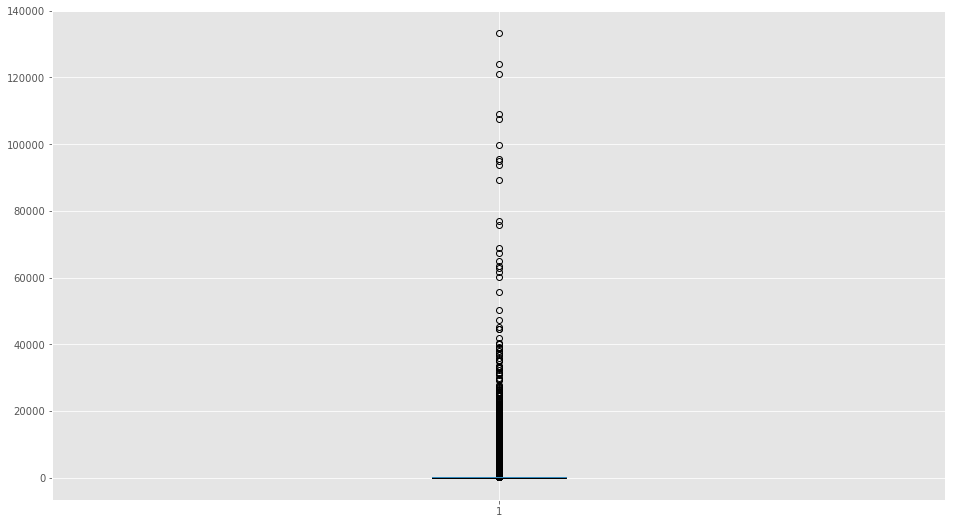

In [9]:
# Outlier treatment
plt.boxplot(queries.cnt)
Q1 = queries.cnt.quantile(0.25)
Q3 = queries.cnt.quantile(0.75)
IQR = Q3 - Q1
queries_1 = queries.cnt[(queries.cnt >= Q1 - 1.5*IQR) & (queries.cnt <= Q3 + 1.5*IQR)]

In [11]:
# Drop search_term
Input = queries.drop("search_term", axis=1)

# Standardise all parameters
standard_scaler = StandardScaler()
standard_scaler.fit_transform(Input)

array([[ 76.99518558],
       [ 71.66345776],
       [ 69.85441673],
       ..., 
       [ -0.12003027],
       [ -0.12003027],
       [ -0.12003027]])

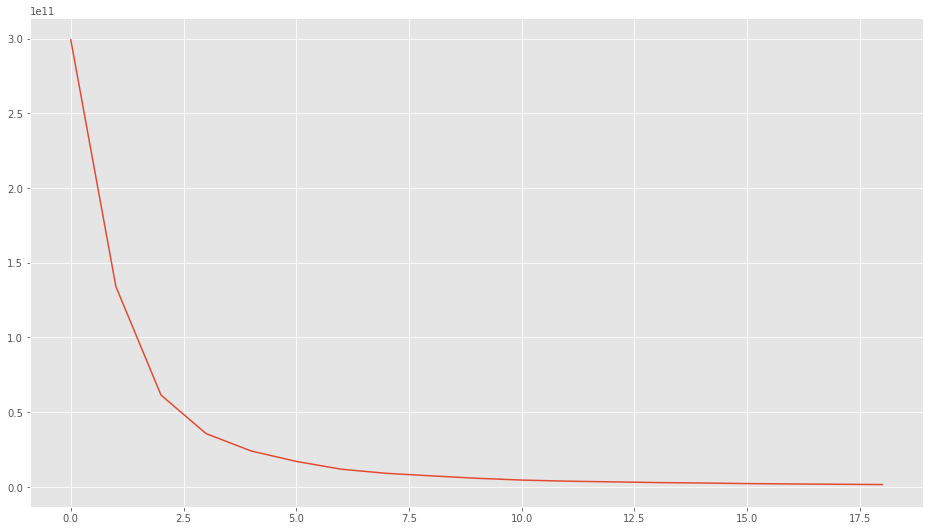

In [12]:
# Sum of squared distances : Elbow method to find optimal number of clusters
ssd = []
for num_clusters in list(range(1,20)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(Input)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [13]:
# Optimal K observed to be 5. Model with 5 clusters
model_cluster5 = KMeans(n_clusters = 5, max_iter=50)
model_cluster5.fit(Input)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
# Getting the cluster labels
labels = model_cluster5.predict(Input)

# Centroid values
centroids = model_cluster5.cluster_centers_

print(centroids)

[[    102.29206127]
 [ 101769.25      ]
 [  17536.32972973]
 [   4612.30713713]
 [  42730.17948718]]


In [15]:
print(labels)

[1 1 1 ..., 0 0 0]


In [16]:
# Analysis of clusters formed
queries.index = pd.RangeIndex(len(queries.index))
queries_km = pd.concat([queries, pd.Series(model_cluster5.labels_)], axis=1)
queries_km.columns = ['cnt', 'search_term', 'cluster']
queries_km.head(5)

,cnt,search_term,cluster
0,133394,polo,1
1,124172,golf,1
2,121043,isuzu,1
3,109099,bmw,1
4,107486,toyota corolla,1


In [17]:
# Cluster groups analysis
km_clusters_cnt = pd.DataFrame(queries_km.groupby(["cluster"]).cnt.mean())
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_cnt], axis=1)
df.columns = ["ClusterID", "cnt_mean"]
df.head()

,ClusterID,cnt_mean
0,0,102.269144
1,1,101769.250000
2,2,17536.329730
3,3,4610.502404
4,4,42730.179487


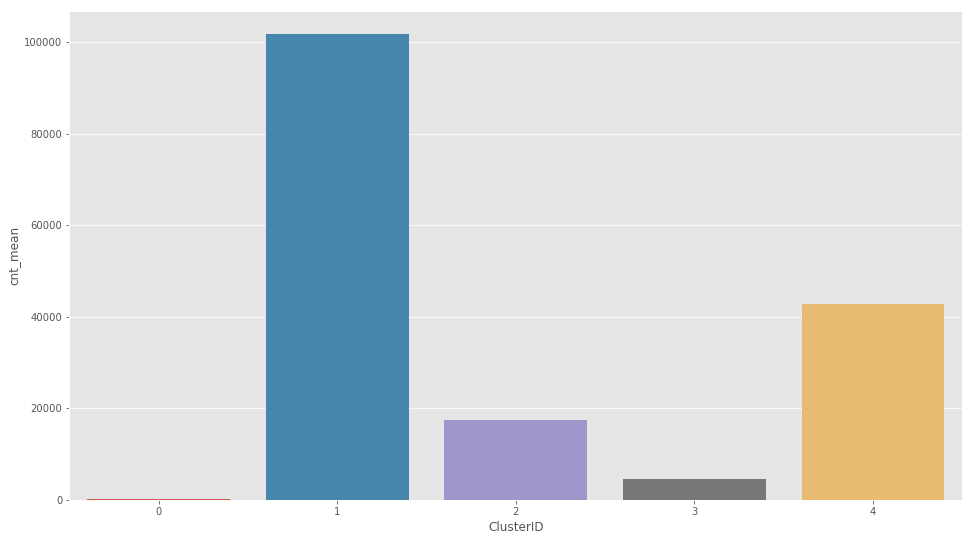

In [18]:
# Mean of term_frequency
sns.barplot(x=df.ClusterID, y=df.cnt_mean)

In [19]:
# Top 10 words by each cluster
queries_km.loc[queries_km['cluster'] == 0].head(10)

,cnt,search_term,cluster
1484,2356,specialized,0
1485,2353,ktm 690,0
1486,2352,vryheid,0
1487,2350,led,0
1488,2350,ford territory,0
1489,2346,iphones,0
1490,2343,westdene,0
1491,2340,belhar,0
1492,2336,malvern,0
1493,2335,telescope,0


In [20]:
queries_km.loc[queries_km['cluster'] == 1].head(10)

,cnt,search_term,cluster
0,133394,polo,1
1,124172,golf,1
2,121043,isuzu,1
3,109099,bmw,1
4,107486,toyota corolla,1
5,99802,toyota,1
6,95592,hilux,1
7,94877,toyota tazz,1
8,93824,cars,1
9,89243,bakkie,1


In [21]:
queries_km.loc[queries_km['cluster'] == 2].head(10)

,cnt,search_term,cluster
51,29988,samsung,2
52,29608,bmw e30,2
53,29367,golf 5 gti,2
54,29176,audi a3,2
55,27671,siyaya,2
56,27588,bmw m3,2
57,27271,caddy,2
58,27088,toyota conquest,2
59,26871,runx,2
60,26610,jeep,2


In [22]:
queries_km.loc[queries_km['cluster'] == 3].head(10)

,cnt,search_term,cluster
236,10954,escort,3
237,10948,polo 6,3
238,10947,xbox 360,3
239,10937,east london,3
240,10878,twincam,3
241,10834,sheep,3
242,10809,renault,3
243,10807,stove,3
244,10758,tools,3
245,10749,velocity golf,3


In [23]:
queries_km.loc[queries_km['cluster'] == 4].head(10)

,cnt,search_term,cluster
12,69001,toyota hilux,4
13,67386,nissan 1400,4
14,64969,mazda 323,4
15,63309,ford ranger,4
16,62821,corolla,4
17,61708,swop,4
18,60122,fridge,4
19,55583,tv,4
20,50215,rims,4
21,47274,damaged,4


In [24]:
# Read sample listing file
listings = pd.read_csv('olx_data_sample/za_sample_listings_incl_cat.csv',
                       low_memory=False,
                       sep = ',',
                       encoding = "ISO-8859-1",
                       header= 0)

listings = listings.loc[:, listings.columns.difference(['Unnamed: 0'])]
print(listings.shape)
listings.head(5)

(500000, 11)


,category_l1_name_en,category_l2_name_en,category_l3_name_en,category_sk,item_id,listing_description,listing_latitude,listing_longitude,listing_price,listing_title,seller_id
0,"Home, Garden & Tools",Garden & Braai,Unknown,olx|mea|za|806|809,0,We build all different types for sale,-25.43067,27.84873,17500.0,Nice wooden makes,0
1,Vehicles,Cars & Bakkies,Chevrolet,olx|mea|za|362|378|2012,1,A Stunning accident free bargain that has just...,-29.73714,31.07364,94890.0,A Shinning 2013 Chevrolet 1.4 Utility Bakkie w...,1
2,"Home, Garden & Tools",Furniture & Decor,Unknown,olx|mea|za|806|807,2,A variety of lampshades in white,-33.88159,18.55522,20.0,Lampshades various,2
3,Vehicles,Cars & Bakkies,Toyota,olx|mea|za|362|378|2067,3,"Toyota Corolla 1.3 Professional, Front Electri...",-26.10757,28.05670,63995.0,Toyota Corolla,3
4,"Home, Garden & Tools",Tools & DIY,Unknown,olx|mea|za|806|910,4,bench grinder and.buffer...R800 for both,-26.17190,27.91318,800.0,bench grinder and buffer,4


In [25]:
# Number of items by each group : Sorted from high to low
listings_pd = pd.DataFrame(listings.groupby('category_l1_name_en')['item_id'].nunique())
listings_pd.columns = ['frequency']
listings_pd.sort_values(['frequency'], ascending=[False])

,frequency
category_l1_name_en,
Vehicles,222200
Electronics & Computers,74481
"Home, Garden & Tools",61725
Services,28892
Property,19754
Sports & Outdoors,15712
Hobbies & Interests,15178
Fashion & Beauty,14452
Farming & Industrial,14376


In [29]:
# Number of Sellers by each group : Sorted from high to low
listings_pd = pd.DataFrame(listings.groupby('category_l1_name_en')['seller_id'].nunique())
listings_pd.columns = ['frequency']
listings_pd.sort_values(['frequency'], ascending=[False]).head(10)

,frequency
category_l1_name_en,
Vehicles,70105
Electronics & Computers,29872
"Home, Garden & Tools",22554
Property,10901
Sports & Outdoors,9431
Services,8867
Hobbies & Interests,8319
Fashion & Beauty,7766
Pets,6139


In [26]:
# Number of Sellers by each group2 : Sorted from high to low
listings_pd = pd.DataFrame(listings.groupby('category_l2_name_en')['item_id'].nunique())
listings_pd.columns = ['frequency']
listings_pd.sort_values(['frequency'], ascending=[False]).head(10)

,frequency
category_l2_name_en,
Cars & Bakkies,155155
Car Parts & Accessories,37308
Furniture & Decor,31555
Cell Phones,28266
Homeware & Appliances,15305
Motorcycles & Scooters,13982
Construction & Home Improvement,12153
Gaming & Consoles,11468
"TV, Audio & Visual",11324


In [27]:
# Number of Sellers by each group3 : Sorted from high to low
listings_pd = pd.DataFrame(listings.groupby('category_l3_name_en')['item_id'].nunique())
listings_pd.columns = ['frequency']
listings_pd.sort_values(['frequency'], ascending=[False]).head(10)

,frequency
category_l3_name_en,
Unknown,317596
Toyota,30718
Volkswagen,28652
Other,13931
Ford,12544
BMW,9999
Opel,9966
Nissan,9375
Mercedes-Benz,7651


In [30]:
# Top sellers by number of Items listed
listings_pd = pd.DataFrame(listings.groupby('seller_id')['item_id'].nunique())
listings_pd.columns = ['frequency']
listings_pd.sort_values(['frequency'], ascending=[False]).head(10)

,frequency
seller_id,
173,1467
192,1309
390,797
10,780
102,704
984,656
222,638
133,603
440,597


In [31]:
listings.head(5)

,category_l1_name_en,category_l2_name_en,category_l3_name_en,category_sk,item_id,listing_description,listing_latitude,listing_longitude,listing_price,listing_title,seller_id
0,"Home, Garden & Tools",Garden & Braai,Unknown,olx|mea|za|806|809,0,We build all different types for sale,-25.43067,27.84873,17500.0,Nice wooden makes,0
1,Vehicles,Cars & Bakkies,Chevrolet,olx|mea|za|362|378|2012,1,A Stunning accident free bargain that has just...,-29.73714,31.07364,94890.0,A Shinning 2013 Chevrolet 1.4 Utility Bakkie w...,1
2,"Home, Garden & Tools",Furniture & Decor,Unknown,olx|mea|za|806|807,2,A variety of lampshades in white,-33.88159,18.55522,20.0,Lampshades various,2
3,Vehicles,Cars & Bakkies,Toyota,olx|mea|za|362|378|2067,3,"Toyota Corolla 1.3 Professional, Front Electri...",-26.10757,28.05670,63995.0,Toyota Corolla,3
4,"Home, Garden & Tools",Tools & DIY,Unknown,olx|mea|za|806|910,4,bench grinder and.buffer...R800 for both,-26.17190,27.91318,800.0,bench grinder and buffer,4


In [32]:
# Filtered to few columns which are planned to use in clustering
listings_filtered = listings.loc[:, listings.columns.isin(['category_l1_name_en',
                                                           'category_l2_name_en',
                                                           'item_id',
                                                           'seller_id',
                                                           'listing_price',
                                                           'listing_latitude',
                                                           'listing_longitude'])]


In [34]:
# Creating a dummy variable for the variable 'Category1' and dropping the source.
cont1 = pd.get_dummies(listings_filtered['category_l1_name_en'], prefix='Cat1_', drop_first=True)
cont2 = pd.get_dummies(listings_filtered['category_l2_name_en'], prefix='Cat2_', drop_first=True)

# Adding the results to the dataframe
listings_filtered = pd.concat([listings_filtered, cont1, cont2],axis=1)
listings_filtered = listings_filtered.drop(['category_l1_name_en', 'category_l2_name_en'], 1)
del [[cont1, cont2]]
listings_filtered.head(5)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,...,Cat2__Rooms for rent & Shared,Cat2__Shop & Catering Equipment,"Cat2__TV, Audio & Visual",Cat2__Toddler's Clothing & Accessories,Cat2__Tools & DIY,"Cat2__Toys, Games & Remote Control",Cat2__Transport,Cat2__Trucks & Commercial Vehicles,Cat2__Vacation Rentals,Cat2__iPads & Tablets
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [35]:
listings_filtered.max()

item_id                                        4.999990e+05
listing_latitude                              -2.238125e+01
listing_longitude                              3.275766e+01
listing_price                                  1.000000e+13
seller_id                                      1.560220e+05
Cat1__Farming & Industrial                     1.000000e+00
Cat1__Fashion & Beauty                         1.000000e+00
Cat1__Hobbies & Interests                      1.000000e+00
Cat1__Home, Garden & Tools                     1.000000e+00
Cat1__Jobs                                     1.000000e+00
Cat1__Kids & Baby                              1.000000e+00
Cat1__Office & Business                        1.000000e+00
Cat1__Pets                                     1.000000e+00
Cat1__Property                                 1.000000e+00
Cat1__Services                                 1.000000e+00
Cat1__Sports & Outdoors                        1.000000e+00
Cat1__Vehicles                          

In [36]:
listings_filtered.min()

item_id                                         0.00000
listing_latitude                              -34.81630
listing_longitude                              16.90045
listing_price                                   0.00000
seller_id                                       0.00000
Cat1__Farming & Industrial                      0.00000
Cat1__Fashion & Beauty                          0.00000
Cat1__Hobbies & Interests                       0.00000
Cat1__Home, Garden & Tools                      0.00000
Cat1__Jobs                                      0.00000
Cat1__Kids & Baby                               0.00000
Cat1__Office & Business                         0.00000
Cat1__Pets                                      0.00000
Cat1__Property                                  0.00000
Cat1__Services                                  0.00000
Cat1__Sports & Outdoors                         0.00000
Cat1__Vehicles                                  0.00000
Cat2__Babysitters, Domestic Help & Cleaning     

In [112]:
'''
listings_filtered['price_log'] = np.log(1 + listings_filtered.listing_price)
listings_filtered = listings_filtered.drop(['listing_price'], 1)

listings_filtered['item_log'] = np.log(1 + listings_filtered.item_id)
listings_filtered = listings_filtered.drop(['item_id'], 1)

listings_filtered['seller_log'] = np.log(1 + listings_filtered.seller_id)
listings_filtered = listings_filtered.drop(['seller_id'], 1)
listings_filtered.head(5)
'''

,item_id,listing_latitude,listing_longitude,seller_id,Category__Farming & Industrial,Category__Fashion & Beauty,Category__Hobbies & Interests,"Category__Home, Garden & Tools",Category__Jobs,Category__Kids & Baby,...,"Category__Home, Garden & Tools",Category__Jobs,Category__Kids & Baby,Category__Office & Business,Category__Pets,Category__Property,Category__Services,Category__Sports & Outdoors,Category__Vehicles,price_log
0,0,-25.43067,27.84873,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,9.770013
1,1,-29.73714,31.07364,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11.460484
2,2,-33.88159,18.55522,2,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,3.044522
3,3,-26.10757,28.05670,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11.066576
4,4,-26.17190,27.91318,4,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,6.685861


In [38]:
# Exclude NaN / Null rows
listings_filtered = listings_filtered.dropna(axis=0, how='any')
# listings_filtered = listings_filtered[np.isfinite(listings_filtered2['listing_price'])]


In [39]:
# Count number of NA / NaN / Null
%timeit
listings_filtered.isnull().values.sum()

0

In [40]:
listings_filtered.head(5)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,...,Cat2__Rooms for rent & Shared,Cat2__Shop & Catering Equipment,"Cat2__TV, Audio & Visual",Cat2__Toddler's Clothing & Accessories,Cat2__Tools & DIY,"Cat2__Toys, Games & Remote Control",Cat2__Transport,Cat2__Trucks & Commercial Vehicles,Cat2__Vacation Rentals,Cat2__iPads & Tablets
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [41]:
# Standardise all parameters
standard_scaler = StandardScaler()
standard_scaler.fit_transform(listings_filtered)

array([[-1.73179592,  0.83987344,  0.19964067, ..., -0.1340033 ,
        -0.04751443, -0.07880637],
       [-1.731789  , -0.61414714,  1.14586889, ..., -0.1340033 ,
        -0.04751443, -0.07880637],
       [-1.73178207, -2.01346388, -2.52718934, ..., -0.1340033 ,
        -0.04751443, -0.07880637],
       ..., 
       [ 1.7317598 , -0.20129223,  0.36446209, ..., -0.1340033 ,
        -0.04751443, -0.07880637],
       [ 1.73176673,  0.68014784,  0.24862585, ..., -0.1340033 ,
        -0.04751443, -0.07880637],
       [ 1.73177366,  0.45000819,  0.24604969, ..., -0.1340033 ,
        -0.04751443, -0.07880637]])

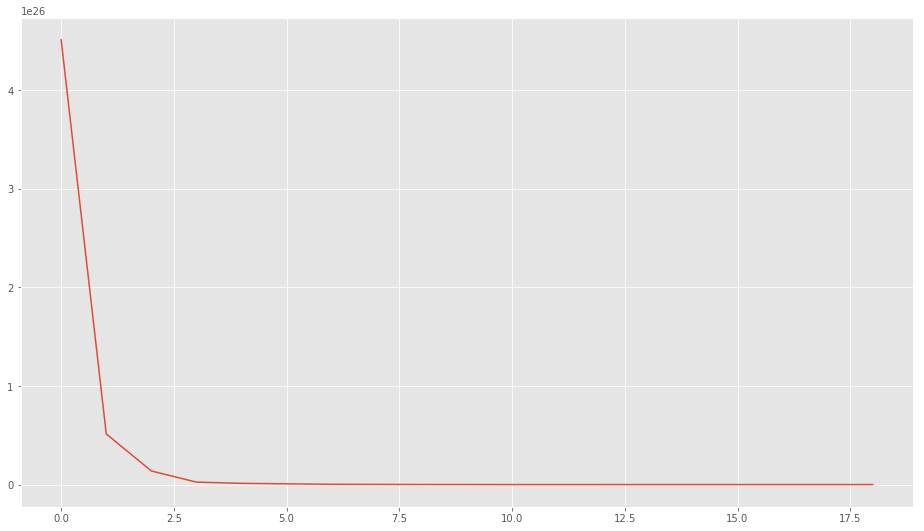

In [42]:
# Sum of squared distances
ssd = []
for num_clusters in list(range(1,20)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(listings_filtered)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [45]:
model_clu = KMeans(n_clusters = 3, max_iter=50)
model_clu.fit(listings_filtered)

# Getting the cluster labels
labels = model_clu.predict(listings_filtered)

# Centroid values
centroids = model_clu.cluster_centers_
print(centroids)

[[  2.50000987e+05  -2.79181730e+01   2.71683003e+01   5.63270986e+06
    4.37442021e+04   2.92211951e-02   2.93655425e-02   2.94427988e-02
    1.25458201e-01   2.64298014e-04   1.31518758e-02   1.65491218e-02
    2.30467868e-02   4.01509345e-02   5.82716130e-02   3.19353324e-02
    4.51723935e-01   1.48616807e-03   7.34951786e-03   5.05825738e-03
    3.70017220e-03   1.39651005e-02   3.00689818e-03   2.62264953e-04
    6.46920217e-03   7.58433648e-02   9.33175297e-03   3.15429515e-01
    5.74665206e-02   1.36093147e-02   3.34235335e-03   1.28652141e-02
    2.21136116e-02   2.43499794e-02   1.45750190e-02   3.78962691e-03
    3.44807256e-03   7.18077374e-03   1.38248192e-03   6.41410619e-02
    2.33110849e-02   1.15864183e-02   5.34695214e-03   7.25193090e-03
    3.11119424e-02   1.89745644e-02   7.37594766e-03   4.48290094e-03
    8.50429688e-03   2.03306165e-06   1.41501091e-03   6.69283895e-03
    2.84242349e-02   5.05825738e-03   5.21683619e-03   1.64068075e-03
    1.48616807e-02  

In [69]:
# Analysis of clusters formed
listings_filtered.index = pd.RangeIndex(len(listings_filtered.index))
listings_filtered_km = pd.concat([listings_filtered, pd.Series(labels, name='ClusterID')], axis=1)
# listings_filtered_km.columns = ['cnt', 'search_term', 'cluster']
listings_filtered_km.head(5)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,...,Cat2__Shop & Catering Equipment,"Cat2__TV, Audio & Visual",Cat2__Toddler's Clothing & Accessories,Cat2__Tools & DIY,"Cat2__Toys, Games & Remote Control",Cat2__Transport,Cat2__Trucks & Commercial Vehicles,Cat2__Vacation Rentals,Cat2__iPads & Tablets,ClusterID
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [71]:
# Cluster groups analysis
km_clusters_price = pd.DataFrame(listings_filtered_km.groupby(["ClusterID"]).listing_price.mean())
df = pd.concat([pd.Series([0,1,2]), km_clusters_price], axis=1)
df.columns = ["ClusterID", "Price_mean"]
df.head()

,ClusterID,Price_mean
0,0,5.632710e+06
1,1,9.997500e+12
2,2,1.487059e+12


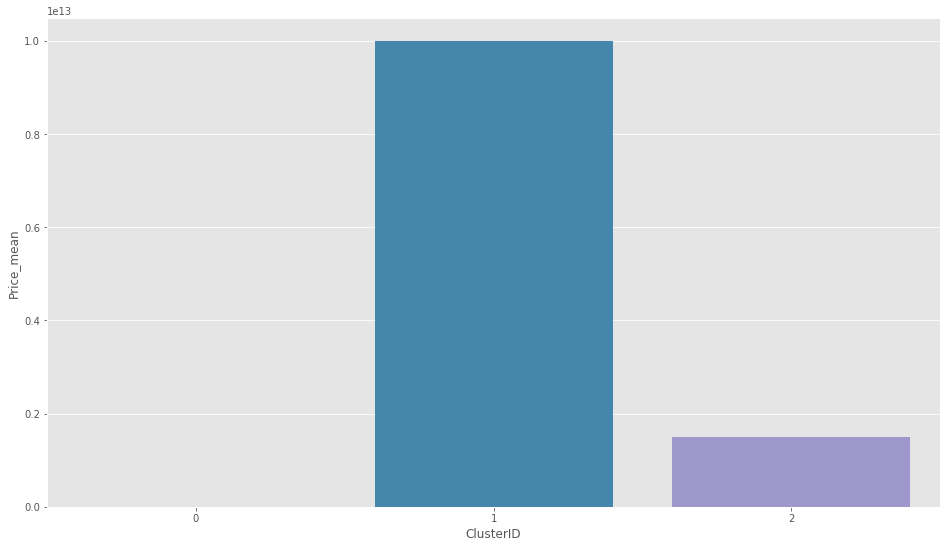

In [72]:
# Mean of term_frequency
sns.barplot(x=df.ClusterID, y=df.Price_mean)

In [73]:
# Top 10 words by each cluster
listings_filtered_km.loc[listings_filtered_km['ClusterID'] == 0].head(10)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,...,Cat2__Shop & Catering Equipment,"Cat2__TV, Audio & Visual",Cat2__Toddler's Clothing & Accessories,Cat2__Tools & DIY,"Cat2__Toys, Games & Remote Control",Cat2__Transport,Cat2__Trucks & Commercial Vehicles,Cat2__Vacation Rentals,Cat2__iPads & Tablets,ClusterID
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,5,-23.66647,27.74483,4700.0,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,6,-34.00845,18.46618,2400.0,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,7,-26.20410,28.04731,90000.0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,-26.22044,27.96590,74990.0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,-26.32239,28.12397,6800.0,9,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Top 10 words by each cluster
listings_filtered_km.loc[listings_filtered_km['ClusterID'] == 1].head(10)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,...,Cat2__Shop & Catering Equipment,"Cat2__TV, Audio & Visual",Cat2__Toddler's Clothing & Accessories,Cat2__Tools & DIY,"Cat2__Toys, Games & Remote Control",Cat2__Transport,Cat2__Trucks & Commercial Vehicles,Cat2__Vacation Rentals,Cat2__iPads & Tablets,ClusterID
23530,23913,-31.98490,29.14924,1.000000e+13,18095,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
81944,83287,-26.03239,28.07422,1.000000e+13,48890,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
152531,155015,-29.13184,26.19502,1.000000e+13,75688,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
445742,453164,-26.54207,28.00690,9.990000e+12,60734,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
# Top 10 words by each cluster
listings_filtered_km.loc[listings_filtered_km['ClusterID'] == 2].head(10)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,...,Cat2__Shop & Catering Equipment,"Cat2__TV, Audio & Visual",Cat2__Toddler's Clothing & Accessories,Cat2__Tools & DIY,"Cat2__Toys, Games & Remote Control",Cat2__Transport,Cat2__Trucks & Commercial Vehicles,Cat2__Vacation Rentals,Cat2__iPads & Tablets,ClusterID
2323,2356,-25.74787,28.22927,1.000000e+12,430,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
15571,15826,-34.02534,18.37420,1.000000e+12,12157,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
29112,29588,-29.13184,26.19502,1.250000e+12,21644,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
106975,108717,-25.80844,28.70814,1.110000e+12,24820,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
154794,157318,-25.80844,28.70814,1.110000e+12,24820,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
259532,263799,-25.48693,30.98190,1.240000e+12,38831,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
281382,285997,-26.01296,28.00543,2.000000e+12,112414,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
310012,315112,-29.38602,24.99025,1.000000e+12,119267,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
315957,321153,-32.95744,27.93662,4.440000e+12,18095,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
329210,334642,-25.69416,31.75089,1.220000e+12,4096,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


### Solution with one group usage

In [76]:
# Filtered to few columns which are planned to use in clustering
listings_filtered_1 = listings.loc[:, listings.columns.isin(['category_l1_name_en',
                                                           'item_id',
                                                           'seller_id',
                                                           'listing_price',
                                                           'listing_latitude',
                                                           'listing_longitude'])]

In [77]:
# Creating a dummy variable for the variable 'Category1' and dropping the source.
cont1 = pd.get_dummies(listings_filtered_1['category_l1_name_en'], prefix='Cat1_', drop_first=True)

# Adding the results to the dataframe
listings_filtered_1 = pd.concat([listings_filtered_1, cont1],axis=1)
listings_filtered_1 = listings_filtered_1.drop(['category_l1_name_en'], 1)
del [[cont1]]
listings_filtered_1.head(5)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,Cat1__Kids & Baby,Cat1__Office & Business,Cat1__Pets,Cat1__Property,Cat1__Services,Cat1__Sports & Outdoors,Cat1__Vehicles
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,0,0,0,0,0,0,1
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,0,0,0,0,0,0,0


In [78]:
listings_filtered_1.max()

item_id                       4.999990e+05
listing_latitude             -2.238125e+01
listing_longitude             3.275766e+01
listing_price                 1.000000e+13
seller_id                     1.560220e+05
Cat1__Farming & Industrial    1.000000e+00
Cat1__Fashion & Beauty        1.000000e+00
Cat1__Hobbies & Interests     1.000000e+00
Cat1__Home, Garden & Tools    1.000000e+00
Cat1__Jobs                    1.000000e+00
Cat1__Kids & Baby             1.000000e+00
Cat1__Office & Business       1.000000e+00
Cat1__Pets                    1.000000e+00
Cat1__Property                1.000000e+00
Cat1__Services                1.000000e+00
Cat1__Sports & Outdoors       1.000000e+00
Cat1__Vehicles                1.000000e+00
dtype: float64

In [79]:
listings_filtered_1.min()

item_id                        0.00000
listing_latitude             -34.81630
listing_longitude             16.90045
listing_price                  0.00000
seller_id                      0.00000
Cat1__Farming & Industrial     0.00000
Cat1__Fashion & Beauty         0.00000
Cat1__Hobbies & Interests      0.00000
Cat1__Home, Garden & Tools     0.00000
Cat1__Jobs                     0.00000
Cat1__Kids & Baby              0.00000
Cat1__Office & Business        0.00000
Cat1__Pets                     0.00000
Cat1__Property                 0.00000
Cat1__Services                 0.00000
Cat1__Sports & Outdoors        0.00000
Cat1__Vehicles                 0.00000
dtype: float64

In [80]:
# Exclude NaN / Null rows
listings_filtered_1 = listings_filtered_1.dropna(axis=0, how='any')

In [81]:
# Count number of NA / NaN / Null
%timeit
listings_filtered_1.isnull().values.sum()

0

In [82]:
listings_filtered_1.head(5)

,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,Cat1__Kids & Baby,Cat1__Office & Business,Cat1__Pets,Cat1__Property,Cat1__Services,Cat1__Sports & Outdoors,Cat1__Vehicles
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,0,0,0,0,0,0,1
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,0,0,0,0,0,0,0


In [83]:
# Standardise all parameters
standard_scaler = StandardScaler()
standard_scaler.fit_transform(listings_filtered_1)

array([[-1.73179592,  0.83987344,  0.19964067, ..., -0.24875046,
        -0.1816243 , -0.90769057],
       [-1.731789  , -0.61414714,  1.14586889, ..., -0.24875046,
        -0.1816243 ,  1.10169703],
       [-1.73178207, -2.01346388, -2.52718934, ..., -0.24875046,
        -0.1816243 , -0.90769057],
       ..., 
       [ 1.7317598 , -0.20129223,  0.36446209, ..., -0.24875046,
        -0.1816243 , -0.90769057],
       [ 1.73176673,  0.68014784,  0.24862585, ...,  4.0200931 ,
        -0.1816243 , -0.90769057],
       [ 1.73177366,  0.45000819,  0.24604969, ..., -0.24875046,
        -0.1816243 , -0.90769057]])

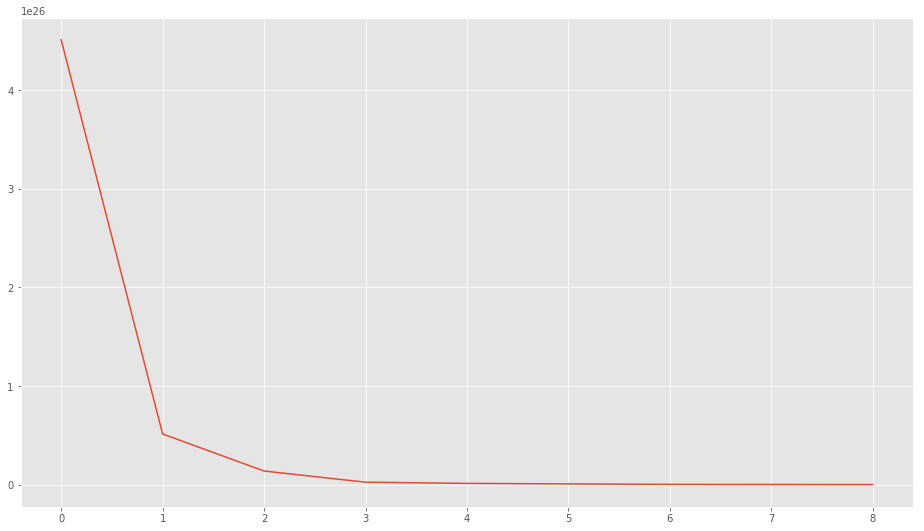

In [85]:
# Sum of squared distances
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(listings_filtered_1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [86]:
model_clu = KMeans(n_clusters = 3, max_iter=50)
model_clu.fit(listings_filtered_1)

# Getting the cluster labels
labels = model_clu.predict(listings_filtered_1)

# Centroid values
centroids = model_clu.cluster_centers_
print(centroids)

[[  2.50000987e+05  -2.79181730e+01   2.71683003e+01   5.63270986e+06
    4.37442021e+04   2.92211951e-02   2.93655425e-02   2.94427988e-02
    1.25458201e-01   2.64298014e-04   1.31518758e-02   1.65491218e-02
    2.30467868e-02   4.01509345e-02   5.82716130e-02   3.19353324e-02
    4.51723935e-01]
 [  1.78844750e+05  -2.84228000e+01   2.78563450e+01   9.99750000e+12
    5.08517500e+04   0.00000000e+00   0.00000000e+00   0.00000000e+00
    5.00000000e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.70213588e+05  -2.79822682e+01   2.75740282e+01   1.48705882e+12
    5.48650000e+04   5.88235294e-02   5.88235294e-02  -1.04083409e-17
    5.88235294e-02   5.42101086e-20   5.88235294e-02   0.00000000e+00
    5.88235294e-02   0.00000000e+00   5.88235294e-02  -1.38777878e-17
    5.88235294e-01]]


In [87]:
# Analysis of clusters formed
listings_filtered_1.index = pd.RangeIndex(len(listings_filtered_1.index))
listings_filtered_1_km = pd.concat([listings_filtered_1, pd.Series(labels, name='ClusterID')], axis=1)
listings_filtered_1_km.head(5)


,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,Cat1__Kids & Baby,Cat1__Office & Business,Cat1__Pets,Cat1__Property,Cat1__Services,Cat1__Sports & Outdoors,Cat1__Vehicles,ClusterID
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,0,0,0,0,0,0,0,0


In [88]:
# Cluster groups analysis
km_clusters_price = pd.DataFrame(listings_filtered_1_km.groupby(["ClusterID"]).listing_price.mean())
df = pd.concat([pd.Series([0,1,2]), km_clusters_price], axis=1)
df.columns = ["ClusterID", "Price_mean"]
df.head()

,ClusterID,Price_mean
0,0,5.632710e+06
1,1,9.997500e+12
2,2,1.487059e+12


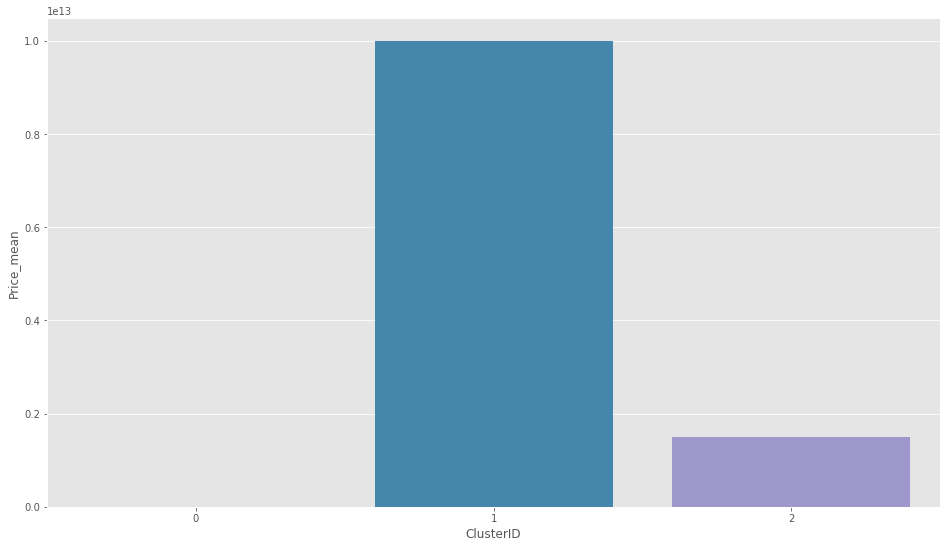

In [89]:
# Mean of term_frequency
sns.barplot(x=df.ClusterID, y=df.Price_mean)

In [90]:
# Top 10 words by each cluster
listings_filtered_1_km.loc[listings_filtered_1_km['ClusterID'] == 0].head(10)


,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,Cat1__Kids & Baby,Cat1__Office & Business,Cat1__Pets,Cat1__Property,Cat1__Services,Cat1__Sports & Outdoors,Cat1__Vehicles,ClusterID
0,0,-25.43067,27.84873,17500.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,-29.73714,31.07364,94890.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,-33.88159,18.55522,20.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3,-26.10757,28.05670,63995.0,3,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,-26.17190,27.91318,800.0,4,0,0,0,1,0,0,0,0,0,0,0,0,0
5,5,-23.66647,27.74483,4700.0,5,0,0,0,1,0,0,0,0,0,0,0,0,0
6,6,-34.00845,18.46618,2400.0,6,0,0,0,1,0,0,0,0,0,0,0,0,0
7,7,-26.20410,28.04731,90000.0,7,0,0,0,0,0,0,0,0,0,0,0,1,0
8,8,-26.22044,27.96590,74990.0,8,0,0,0,0,0,0,0,0,0,0,0,1,0
9,9,-26.32239,28.12397,6800.0,9,0,0,0,1,0,0,0,0,0,0,0,0,0


In [91]:
# Top 10 words by each cluster
listings_filtered_1_km.loc[listings_filtered_1_km['ClusterID'] == 1].head(10)


,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,Cat1__Kids & Baby,Cat1__Office & Business,Cat1__Pets,Cat1__Property,Cat1__Services,Cat1__Sports & Outdoors,Cat1__Vehicles,ClusterID
23530,23913,-31.98490,29.14924,1.000000e+13,18095,0,0,0,1,0,0,0,0,0,0,0,0,1
81944,83287,-26.03239,28.07422,1.000000e+13,48890,0,0,0,0,0,0,0,0,0,0,0,0,1
152531,155015,-29.13184,26.19502,1.000000e+13,75688,0,0,0,1,0,0,0,0,0,0,0,0,1
445742,453164,-26.54207,28.00690,9.990000e+12,60734,0,0,0,0,0,0,0,0,0,0,0,0,1


In [92]:
# Top 10 words by each cluster
listings_filtered_1_km.loc[listings_filtered_1_km['ClusterID'] == 2].head(10)


,item_id,listing_latitude,listing_longitude,listing_price,seller_id,Cat1__Farming & Industrial,Cat1__Fashion & Beauty,Cat1__Hobbies & Interests,"Cat1__Home, Garden & Tools",Cat1__Jobs,Cat1__Kids & Baby,Cat1__Office & Business,Cat1__Pets,Cat1__Property,Cat1__Services,Cat1__Sports & Outdoors,Cat1__Vehicles,ClusterID
2323,2356,-25.74787,28.22927,1.000000e+12,430,0,0,0,0,0,1,0,0,0,0,0,0,2
15571,15826,-34.02534,18.37420,1.000000e+12,12157,0,0,0,0,0,0,0,0,0,0,0,1,2
29112,29588,-29.13184,26.19502,1.250000e+12,21644,0,0,0,0,0,0,0,1,0,0,0,0,2
106975,108717,-25.80844,28.70814,1.110000e+12,24820,0,0,0,0,0,0,0,0,0,0,0,1,2
154794,157318,-25.80844,28.70814,1.110000e+12,24820,0,0,0,0,0,0,0,0,0,0,0,1,2
259532,263799,-25.48693,30.98190,1.240000e+12,38831,0,0,0,0,0,0,0,0,0,0,0,1,2
281382,285997,-26.01296,28.00543,2.000000e+12,112414,0,1,0,0,0,0,0,0,0,0,0,0,2
310012,315112,-29.38602,24.99025,1.000000e+12,119267,1,0,0,0,0,0,0,0,0,0,0,0,2
315957,321153,-32.95744,27.93662,4.440000e+12,18095,0,0,0,0,0,0,0,0,0,1,0,0,2
329210,334642,-25.69416,31.75089,1.220000e+12,4096,0,0,0,0,0,0,0,0,0,0,0,1,2
